In [12]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.mii_home: /Users/trafferty/dev
 paths.images_root: /Users/trafferty/data/images
 paths.inhouse: /Users/trafferty/dev/inhouse
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.tmp_dir: /Users/trafferty/tmp
 paths.results_root: /Users/trafferty/data/results
 paths.projects_root: /Users/trafferty/data/projects
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.ws_dir: /Users/trafferty/workspace


### Read in an image, some anotation, plotting

In [2]:
cb1_path=paths.images_root+'/checkerboard1.png'
cb_normal_path=paths.images_root+'/checkerboard_normal.png'
cb_barrel_path=paths.images_root+'/checkerboard_barrel.png'
cb_pincushion_path=paths.images_root+'/checkerboard_pincushion.png'

cb_normal = cv2.imread(cb_normal_path,cv2.IMREAD_GRAYSCALE)
cb_barrel = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)
cb_pincushion = cv2.imread(cb_pincushion_path,cv2.IMREAD_GRAYSCALE)

default_path = cb1_path
def read_image():
    cb_img = cv2.imread(default_path,cv2.IMREAD_GRAYSCALE)
    rows, cols = cb_img.shape
    midX, midY = int(cols/2), int(rows/2)
    return cb_img[midY-90:midY+90, midX-100:midX+100]  #np slice: [startY:endY, startX:endX]

def subimage2(image, center, theta, width, height):
    #theta = np.deg2rad(theta)

    v_x = (np.cos(theta), np.sin(theta))
    v_y = (-np.sin(theta), np.cos(theta))
    s_x = center[0] - v_x[0] * (width / 2) - v_y[0] * (height / 2)
    s_y = center[1] - v_x[1] * (width / 2) - v_y[1] * (height / 2)

    mapping = np.array([[v_x[0],v_y[0], s_x],
                        [v_x[1],v_y[1], s_y]])

    return cv2.warpAffine(image,mapping,(width, height),flags=cv2.WARP_INVERSE_MAP,borderMode=cv2.BORDER_REPLICATE)

# img = cv2.imread('../images/owl.jpg', -1)
# print( img.shape)
# patch = subimage2(img, (110, 125), np.pi / 6.0, 100, 200)


In [3]:
cb_img_roi = read_image()

rows, cols = cb_img_roi.shape
midX, midY = int(cols/2), int(rows/2)
cb_img_rotated = subimage2(cb_img_roi, (midX, midY), np.pi/35.0, cols, rows)

util.plot_imgs([(cb_img,'checkerboard'), (cb_img_roi,'checkerboard ROI'), (cb_img_rotated,'checkerboard Rotated'),
               (cb_normal,'cb_normal'), (cb_barrel,'cb_barrel'), (cb_pincushion,'cb_pincushion')], max_cols = 3)

NameError: name 'cb_img' is not defined

In [4]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


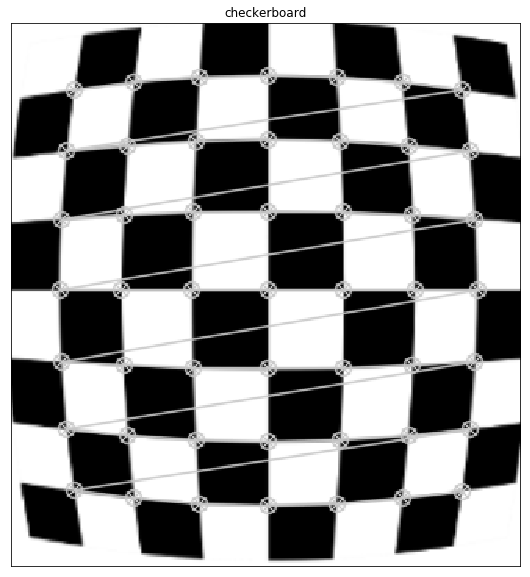

In [5]:
#cb_img_roi = read_image()
cb_img_roi = cb_barrel

rows, cols = cb_img_roi.shape
midX, midY = int(cols/2), int(rows/2)
#cb_img_rotated = subimage2(cb_img_roi, (midX, midY), np.pi/40.0, cols, rows)
cb_img_rotated = cb_img_roi

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(cb_img_rotated, (7,7), None)

# If found, add object points, image points (after refining them)
if ret == True:
    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(cb_img_rotated, corners,(11,11),(-1,-1),criteria)
    imgpoints.append(corners2)

    # Draw and display the corners
    cb_img2 = cv2.drawChessboardCorners(cb_img_rotated, (7,7), corners2,ret)

    util.plot_imgs([(cb_img2,'checkerboard')], max_cols = 2)
else:
    print("Not Found...")


In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cb_img_rotated.shape[::-1],None,None)


In [7]:
h,  w = cb_img_rotated.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

/Users/trafferty/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/Users/trafferty/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


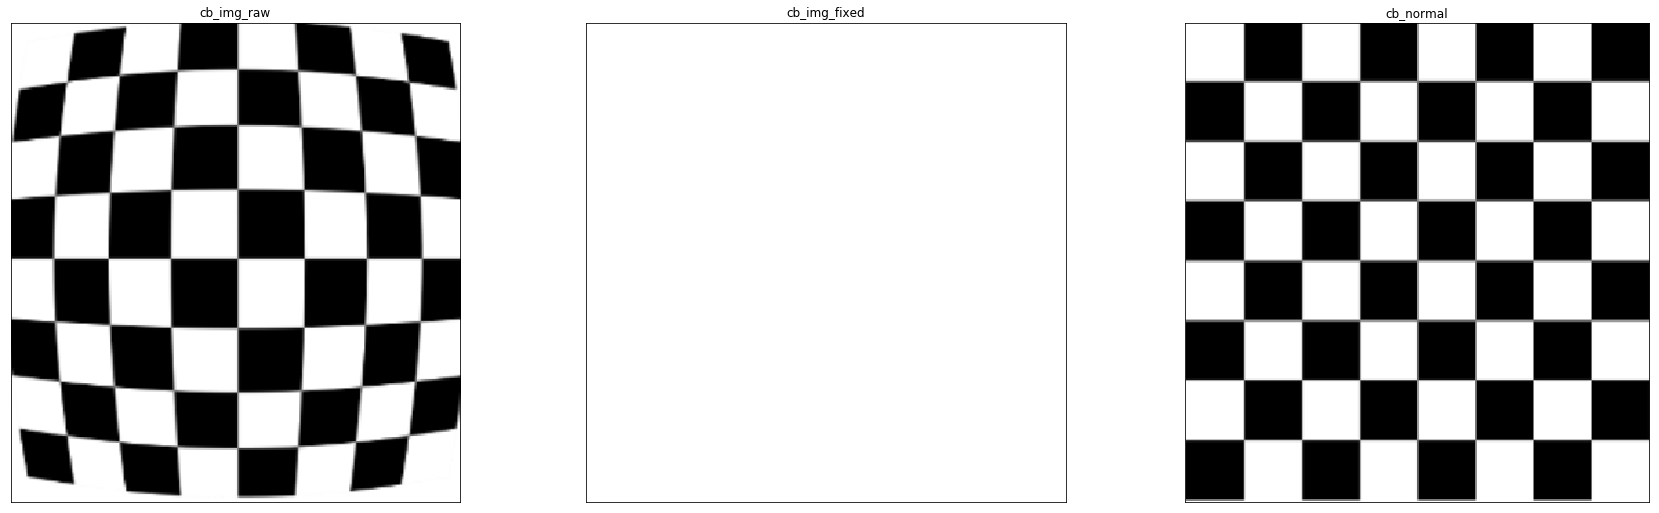

In [8]:
cb_img_in = read_image()
cb_img_raw = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)


# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(cb_img_raw, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
cb_img_fixed = dst[y:y+h, x:x+w]

util.plot_imgs([(cb_img_raw,'cb_img_raw'), (cb_img_fixed,'cb_img_fixed'), (cb_normal,'cb_normal')], max_cols = 3)

2160.0


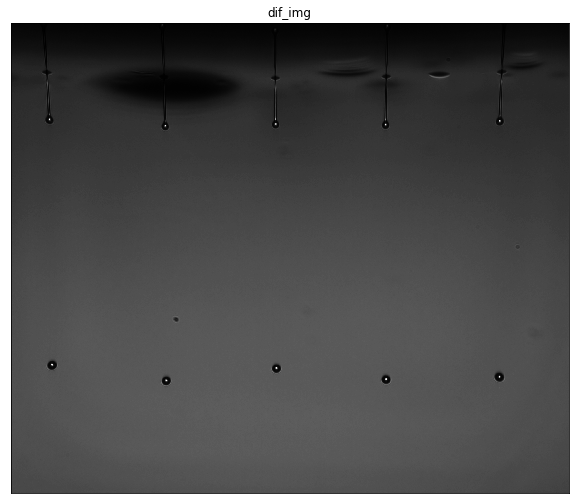

In [9]:
idx = 1
DIF2_path = paths.images_root+'/dif/DIF2_OCE_images/DIFCapture_0%d.tif' % (idx)

dif_img_raw = cv2.imread(DIF2_path, cv2.IMREAD_GRAYSCALE)
rows, cols = dif_img_raw.shape
midX, midY = int(cols/2), int(rows/2)
print(rows/2)

dif_img = dif_img_raw[1:int(rows/2), 1:cols]  #np slice: [startY:endY, startX:endX]

util.plot_imgs([(dif_img,'dif_img')], max_cols = 3)

(2159, 2559)
(348, 326)
(2159, 2559)


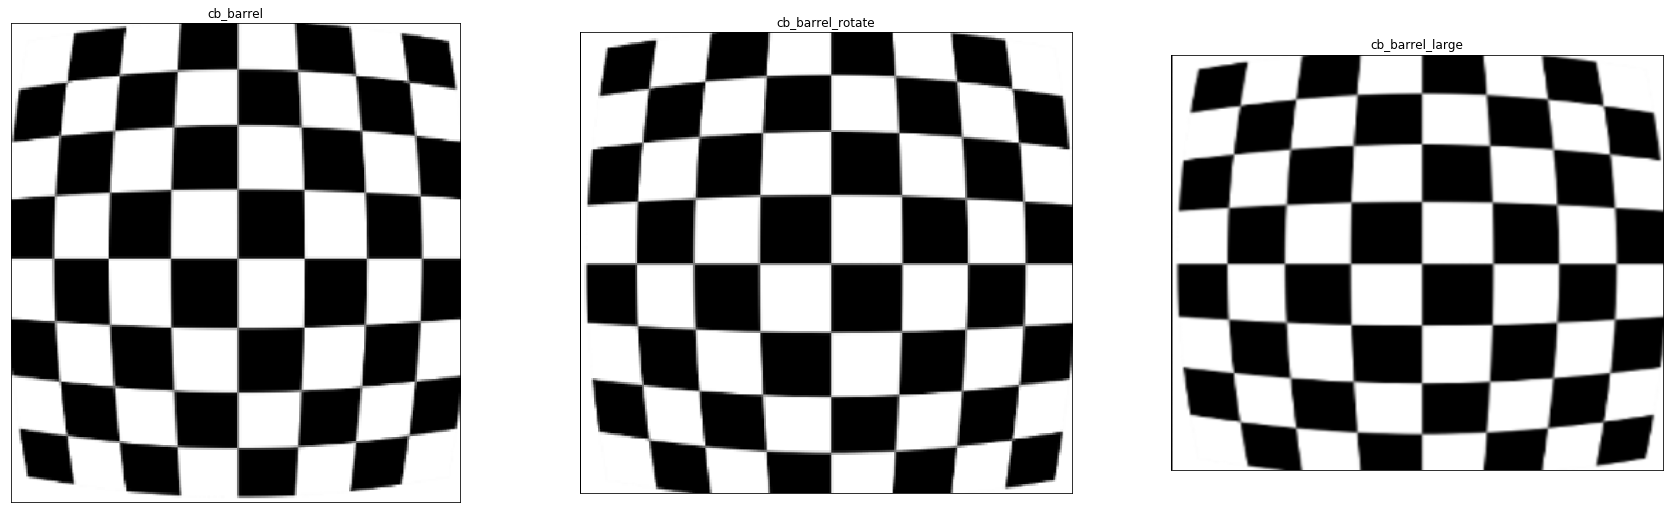

In [15]:
rows, cols = dif_img.shape

cb_barrel = cv2.imread(cb_barrel_path,cv2.IMREAD_GRAYSCALE)
cb_barrel_rotate = imutils.rotate_bound(cb_barrel, 90)
cb_barrel_large = cv2.resize(cb_barrel_rotate, (cols, rows))

for img in [dif_img, cb_barrel, cb_barrel_large]:
    print("(%d, %d)" % (img.shape[0], img.shape[1]))
    
util.plot_imgs([(cb_barrel,'cb_barrel'), (cb_barrel_rotate,'cb_barrel_rotate'), (cb_barrel_large,'cb_barrel_large')], max_cols = 3)

In [16]:
cb_img = cb_barrel_large

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(cb_img, (7,7), None)

# If found, add object points, image points (after refining them)
if ret == True:
    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(cb_img, corners,(11,11),(-1,-1),criteria)
    imgpoints.append(corners2)

    # Draw and display the corners
    cb_img2 = cv2.drawChessboardCorners(cb_img, (7,7), corners2,ret)

    util.plot_imgs([(cb_img2,'checkerboard')], max_cols = 2)
else:
    print("Not Found...")


Not Found...


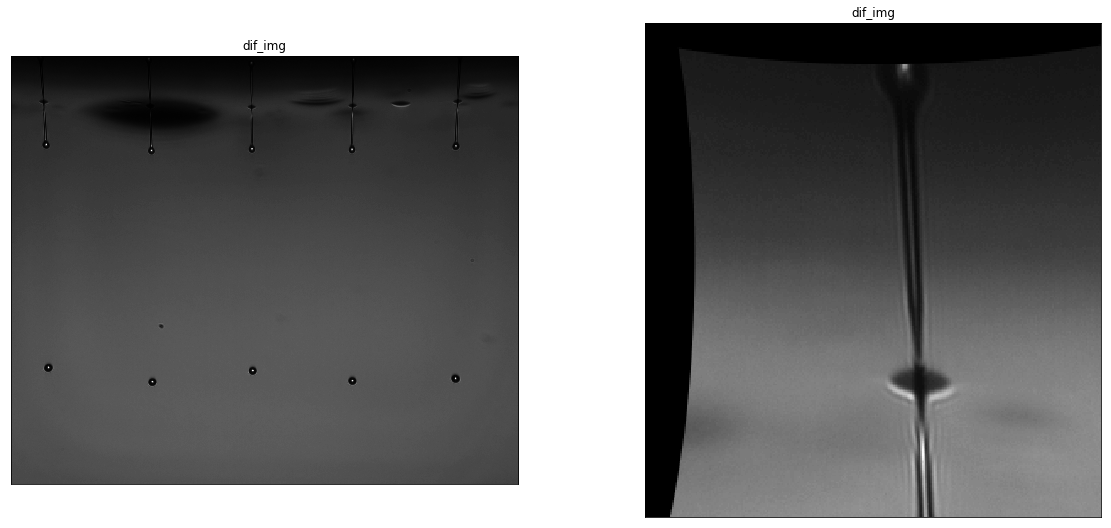

In [64]:
# undistort
dst = cv2.remap(dif_img, mapx, mapy, cv2.INTER_LINEAR)

# # crop the image
# x,y,w,h = roi
# cb_img_fixed = dst[y:y+h, x:x+w]

util.plot_imgs([(dif_img,'dif_img'), (dst,'dif_img')], max_cols = 3)